### Create a .yaml "driver" file with assumptions that we may want to change over time.

The cargo and fuel capacity values and references are in [this google spreadsheet](https://docs.google.com/spreadsheets/d/1URKN77iQHN-2cAVfG5T7SEiDTLTcolqL/edit#gid=1024416588)

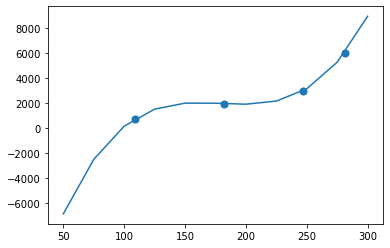

In [1]:
import sys
import yaml
import pathlib
import numpy
import matplotlib.pyplot as plt

output_directory = pathlib.Path('/Users/rmueller/Projects/MIDOSS/analysis-rachael/notebooks/monte_carlo/')
output_file      = output_directory / 'master.yaml'


tank_data_types  =  ['probability_cargo',
                     'probability_fuel', 
                     'min_cargo',
                     'max_cargo', 
                     'min_fuel', 
                     'max_fuel']
other_data_types = ['min_fuel', 
                     'max_fuel']

master = {}

# create a section for directories and filenames
# US_origin is for US as origin
# US_all represents the combined import and export of fuel
master['directories'] = '/Users/rmueller/Projects/MIDOSS/analysis-rachael/notebooks/monte_carlo/'
master['files'] = {}
master['files']['CAD_origin']     = 'CAD_origin.yaml'
master['files']['WA_destination'] = 'WA_destination.yaml'
master['files']['WA_origin']      = 'WA_origin.yaml'
master['files']['US_origin']      = 'US_origin.yaml'
master['files']['US_combined']    = 'US_all.yaml'
master['files']['Pacific_origin'] = 'Pacific_origin.yaml'
master['files']['fuel']           = 'fuel_by_vessel.yaml'

# create a section for general categories 
master['categories'] = {}

# labels for AIS ship traffic groups
master['categories']['all_vessels'] = [
    'tanker', 'atb', 'barge', 'cargo', 'cruise',
    'ferry', 'fishing', 'smallpass', 'other'
]

# labels for oil tank traffic identified in AIS
master['categories']['tank_vessels'] = [
    'tanker', 'atb', 'barge'
]

# fuel types used in categorizing Dept. of Ecology data and 
# for which we have Lagrangian files (with the exception of 'other')
master['categories']['fuel_type']    = [
    'akns', 'bunker', 'dilbit', 'jet', 
    'diesel', 'gas', 'other'
]

# tanker size classes (still in considerations)
master['categories']['tanker_size_classes'] = [
    'Small Tanker (< 150 m)', 'Handymax (151-200 m)', 
    'Aframax (201-250 m)', 'SuezMax (251-300 m)' 
     ]

# labels given to ship tracks in our AIS origin-destination analysis
# but that lack an origin or destination in our marine terminal list
# because (a) It's a part of a voyage < 2 km, (b) It's part of a voyage
# > 2 km but with a start or end that isn't connected to marine terminal
master['categories']['generic_origin_destination'] = [
    'Pacific',
    'US',
    'Canada'
]
master['categories']['CAD_origin_destination'] = [
    'ESSO Nanaimo Departure Bay',
    'Suncor Nanaimo',
    'Shell Chemainus Bare Point',
    'Chevron Cobble Hill',
    'Chevron Stanovan',
    'Barge Mooring Near Stanovan',
    'Shell Shellburn',
    'Westridge Marine Terminal',
    'ESSO IOCO Vancouver',
    'Suncor Vancouver'
]
master['categories']['US_origin_destination'] = [ 
    'BP Cherry Point Refinery', 
    'Shell Puget Sound Refinery', 
    'Shell Oil LP Seattle Distribution Terminal',
    'Maxum (Rainer Petroleum)', 
    'Tidewater Snake River Terminal',
    'Nustar Energy Tacoma', 
    'SeaPort Sound Terminal', 
    'Tesoro Vancouver Terminal',
    'Phillips 66 Ferndale Refinery', 
    'Phillips 66 Tacoma Terminal', 
    'Andeavor Anacortes Refinery (formerly Tesoro)',
    'Tesoro Port Angeles Terminal',
    'U.S. Oil & Refining',
    'Naval Air Station Whidbey Island (NASWI)',
    'NAVSUP Manchester', 
    'Alon Asphalt Company (Paramount Petroleum)', 
    'Kinder Morgan Liquids Terminal - Harbor Island', 
    'Tesoro Pasco Terminal', 
    'REG Grays Harbor, LLC', 
    'Tidewater Vancouver Terminal',
    'TLP Management Services LLC (TMS)']

# create sections organized by vessel type
master['vessel_attributes'] = {}

for vessels in master['categories']['all_vessels']:
    master['vessel_attributes'][f'{vessels}'] = {}
    if f'{vessels}' in ['tanker', 'atb', 'barge']:
        for data in tank_data_types:
            master['vessel_attributes'][f'{vessels}'][f'{data}']={}
    for data in other_data_types:
        master['vessel_attributes'][f'{vessels}'][f'{data}']={}

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# define tanker size classes and the HFO/diesel ratio of fuel capacity
# The HFO/diesel ratios are taken from https://silo.tips/download/suezmax-oil-tanker-tankers-166300-dwt
master['vessel_attributes']['tanker']['tanker_types'] = master['categories']['tanker_size_classes']
master['vessel_attributes']['tanker']['fuel_hfo_to_diesel'] = [
    687/53, 1826/130, 2822/162, 4025/130   
]
master['vessel_attributes']['tanker']['fuel_capacity'] = [
    740, 1956, 2984, 5986.7,   
]
# These are the lengths of the vessels in the above website that correspond
# to the fuel ratios  and fuel capacities listed above
master['vessel_attributes']['tanker']['vessel_lengths'] = [
    108.5, 182, 247.24, 281
]

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Calculate cubic polynomial fit for tanker traffic fuel capacity by 
# vessel length
master['vessel_attributes']['tanker']['cubic_coefs'] = numpy.polyfit(
    numpy.array(master['vessel_attributes']['tanker']['vessel_lengths']), 
    numpy.array(master['vessel_attributes']['tanker']['fuel_capacity']), 
    3
).tolist()
# just because I don't want a super LONG equation!
C = numpy.array(master['vessel_attributes']['tanker']['cubic_coefs'])
master['vessel_attributes']['tanker']['cubic_fit'] = (
    C[3] + 
    C[2]*numpy.array(master['vessel_attributes']['tanker']['vessel_lengths']) + 
    C[1]*numpy.power(numpy.array(master['vessel_attributes']['tanker']['vessel_lengths']),2) + 
    C[0]*numpy.power(numpy.array(master['vessel_attributes']['tanker']['vessel_lengths']),3)
).tolist()

## reality-check plot fit
test_length = range(50, 320, 25)
fit = (
    C[3] + 
    C[2]*test_length + 
    C[1]*numpy.power(test_length,2) + 
    C[0]*numpy.power(test_length,3)
)
fig1 = plt.figure()                                                                                           
ax1 = fig1.add_subplot(111)                                                                                   
ax1.scatter(
    master['vessel_attributes']['tanker']['vessel_lengths'][:], 
    master['vessel_attributes']['tanker']['fuel_capacity'][:], 
    50
)                                                                     
ax1.plot(test_length, fit)                                                                     
plt.show()

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Set the probability of incident as fuel spill vs. cargo spill for 
#  oil-cargo vessels.  I use probability-of-cargo = 1-(probability-of-fuel) 
#  to ensure sum of 1. 
master['vessel_attributes']['tanker']['probability_fuel']  = 0.2
master['vessel_attributes']['tanker']['probability_cargo'] = 1 - \
    master['vessel_attributes']['tanker']['probability_fuel']

master['vessel_attributes']['atb']['probability_fuel']  = 0.2
master['vessel_attributes']['atb']['probability_cargo'] = 1 - \
    master['vessel_attributes']['atb']['probability_fuel']

master['vessel_attributes']['barge']['probability_fuel']  = 0.2
master['vessel_attributes']['barge']['probability_cargo'] = 1 - \
    master['vessel_attributes']['barge']['probability_fuel']

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Set the probability of a barge carrying oil-cargo for a ship track 
#  that is identified as barge but that lacks origin-destination information 
master['vessel_attributes']['barge']['probability_oilcargo'] = 0.5

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## set minimum cargo capacities in liters
master['vessel_attributes']['tanker']['min_cargo'] = 34000000  # ATB size 
master['vessel_attributes']['atb']['min_cargo']    =  1500000  # 1589873 pg. 3A-10 of [DOE report](https://fortress.wa.gov/ecy/publications/documents/96250.pdf)
master['vessel_attributes']['barge']['min_cargo']  =  1500000

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## set maximum cargo capacities in liters
master['vessel_attributes']['tanker']['max_cargo'] = 159000000 # Corresponding to tank capacity of Suez-Max tankers as AIS data shows tanker lengths up to 287 m
master['vessel_attributes']['atb']['max_cargo']    =  35000000  
master['vessel_attributes']['barge']['max_cargo']  =  32000000 # 31,797,444  #F99 of excel sheet and 3A-10 of [DOE report](https://fortress.wa.gov/ecy/publications/documents/96250.pdf)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Set fuel size classes 
# Tankers: SuezMax (285 m), Aframax (245 m), Handymax (180 m), Small Tanker (116 m)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## set minimum fuel capacities in liters
# PLACEHOLDER[Needs AIS verification]: Reflects Handy-size tanker in 
# https://silo.tips/download/suezmax-oil-tanker-tankers-166300-dwt
#
master['vessel_attributes']['tanker']['min_fuel_bunker']    = 180000 
master['vessel_attributes']['tanker']['min_fuel_diesel']    = 130000
# End PLACEHOLDER
master['vessel_attributes']['atb']['min_fuel']       = 99000   # Based on Island Raider and Island Regent tugs in Charles Costanzo's `ATB Information AWO Edits`
master['vessel_attributes']['barge']['min_fuel']     = 6000    # 5678 (F43): Harbour Tug
master['vessel_attributes']['cargo']['min_fuel']     = 1500000 # 1,514,164
master['vessel_attributes']['cruise']['min_fuel']    = 3500000 # 3,785,410
master['vessel_attributes']['ferry']['min_fuel']     = 30000   # 34,068
master['vessel_attributes']['fishing']['min_fuel']   = 150
master['vessel_attributes']['smallpass']['min_fuel'] = 150
master['vessel_attributes']['other']['min_fuel']     = 20   # 22 (F52)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## set maximum fuel capacities in liters (to be filled in )
# NOTE: Max volume for ferries reflects WA ferries.  See "Other Ship Classifications"
# and Living Oceans information with reference to [BC ferries doc](http://ferriesbc.proboards.com/thread/7592/fueling-bcs-ferries)

# PLACEHOLDER[Needs AIS verification]: Reflects Handy-size tanker in 
# https://silo.tips/download/suezmax-oil-tanker-tankers-166300-dwt
master['vessel_attributes']['tanker']['max_fuel_bunker']    = 0
master['vessel_attributes']['tanker']['max_fuel_diesel']    = 0
# End PLACEHOLDER

# NOTE: Ocean-going tank barge listed as 52,995,000 liters max fuel capacity 
# accoring to [NOAA](https://response.restoration.noaa.gov/about/media/how-much-oil-ship.html)
master['vessel_attributes']['atb']['max_fuel']       = 550000    # Again, based on Dublin Sea Charles Costanzo's 
master['vessel_attributes']['barge']['max_fuel']     = 710000    # 700,300: Ocean Tug (need to verify that we have them in S.S.)
master['vessel_attributes']['cargo']['max_fuel']     = 20000000  # 1,7034,345
master['vessel_attributes']['cruise']['max_fuel']    = 5500000   # 5,149,456
master['vessel_attributes']['ferry']['max_fuel']     = 500000    # 492,103. 
master['vessel_attributes']['fishing']['max_fuel']   = 300000    # 283,906  (see p. 3A-6 of [DOE report](https://fortress.wa.gov/ecy/publications/documents/96250.pdf))
master['vessel_attributes']['smallpass']['max_fuel'] = 12000     # 11356 (F41)
master['vessel_attributes']['other']['max_fuel']     = 3100      # 3,028 (F77): Cruising, sport fishing, sailing

# if driver['tank_fuel_probability'] + driver['tank_cargo_probability'] != 1:
#     sys.error('fuel vs. cargo probability needs is not adding to 1')

with open(output_file, 'w') as file:
    documents = yaml.dump(master, file)